## Progetto Apprendimento Automatico - Gennaio 2024
## Luca Panariello

#Deblurring di immagini mosse

Il progetto riguarda il deblurirng di immagini. Il tipo di "blur" in questione è ottenuto mediante sovrapposizione di immagini leggermente traslate a partire dall'originale, lungo un tragitto randomico.

Questo tipo di blur ntende simulare il risultato del tremolio della mano per riprese con tempo di esposizione prolungato.

In [ ]:
from keras import layers, optimizers, losses, metrics, initializers, callbacks
from keras.models import Model, Sequential
from keras.datasets import mnist
import sklearn.model_selection as skms
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def generator(dataset,batchsize,moves=10):
  while True:
    rand = np.random.randint(dataset.shape[0],size=batchsize)
    y_truth = dataset[rand]
    blurred = np.copy(y_truth)
    moving = tf.expand_dims(y_truth,axis=-1)

    for i in range(moves):
      #RandomTranslation requires a channel axis
      moving = layers.RandomTranslation(0.07,0.07,fill_mode='constant',interpolation='bilinear')(moving)
      blurred = blurred + tf.squeeze(moving)
    blurred = blurred/(moves+1)
    yield(blurred,y_truth)

def plot(x,y,z):
  no = x.shape[0]
  print(no)
  plt.figure(figsize=(2*no, 6))
  for i in range(no):

    # display original
    ax = plt.subplot(3, no, i + 1)
    plt.imshow(x[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == 0:
      ax.set_title('Blurred images')

    # display blurred
    ax = plt.subplot(3, no, i + 1 + no)
    plt.imshow(y[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == 0:
      ax.set_title('Deblurred images')

    # display reconstruction
    ax = plt.subplot(3, no, i + 1 + 2*no)
    plt.imshow(z[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == 0:
      ax.set_title('Original images')
  plt.show()


Lavoriamo da immagini ottenute a partire da MNIST

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = (x_train/255.).astype(np.float32)
x_test = (x_test/255.).astype(np.float32)

blurred_train,true_train = next(generator(x_train,x_train.shape[0]))

blurred_val,true_val = next(generator(x_test,x_test.shape[0]))

11490434/11490434 [==============================] - 2s 0us/step


#Il Modello CNN
Per il deblur delle immagini, ho scelto di utilizzare una CNN anziché un auto-encodeder, volevo focalizzarmi su un approccio "riparativo", anziché uno decostruttivo-ricostruttivo, ho evitato quindi l'uso di stride e downsampling.

Ho suddiviso la rete un due parti:


*   Parte Superficiale
*   Parte Profonda


#Parte Superficiale
La Parte Superficiale si occupare di rilevare lo sfuocamento ed è composta da Blocchi di 3 layer, con numeri di filtri crescente: questo per apprendere le caratterestiche più "grezze", come intensità e direzione dello sfuocamento.

Ho scelto di utilizzare la tecnica del "*Stacking Layer*" per simulare un layer con kernel 7x7 usando 3 layer con kernel 3x3, ma utilizzando molti meno parametri, velocizzando l'apprendimento e migliorandone i risultati. (fonte: https://www.sicara.fr/blog-technique/2019-10-31-convolutional-layer-convolution-kernel)

Ho usato dei layer di **Dropout** impostati al 10% in modo evitare il fenomeno di overfitting.

Infine come funzione di attivazione ho fatto uso della **PReLu** ovvero una funzione definita:

$\begin{equation}
  \text{PReLU}(x, \alpha) =
      \begin{cases}
          x, & \text{se } x \geq 0, \\
          \alpha x, & \text{se } x < 0.
      \end{cases}
  \end{equation}
$

dove $α$ è un parametro appreso durante la backpropagation, ovvero la rete tende a imparare quale *LeakyReLU* è la migliore per rilevare le feature necessarie.
Nonostante l'aumento dei paramentri, ho notato una diminuzione della loss.

Ad ogni attivazione dei Layer ho aggiunto un layer di **BatchNormalization**, che effettua una standardizzazione sul batch di dati durante l'inferenza, per migliorare la convergenza del modello.

#Parte Profonda

La parte profonda è molto simile a quella superficiale, i filtri in questo caso decrescono, in modo da dimunuire la complessità e selezionale le features importanti per l'output.

Mentre come funzione di attivazione ho scelto di usare la SiLU [Sigmoid ReLU] definita in questo modo:

$\begin{equation}
  \text{SiLU}(x, \alpha) = x ⋅ σ(x)
  \end{equation}
$

Dove $σ$ è la funzione sigmoidale, ho scelto la SiLU perché riesce a passare meglio le informazioni da gli strati di *LeakyReLU* fino allo strato di output che usa una semplice sigmoide.

In [ ]:
def DeblurringNet():

    Layers = [
        layers.Input(shape=(28,28,1)),
        layers.Normalization(),


        layers.Conv2D(16, (3, 3), activation=layers.PReLU(), padding="same"),
        layers.BatchNormalization(),

        layers.Conv2D(16, (3, 3), activation=layers.PReLU(), padding="same"),
        layers.BatchNormalization(),

        layers.Conv2D(16, (3, 3), activation=layers.PReLU(), padding="same"),
        layers.BatchNormalization(),


        layers.Conv2D(16, (3, 3), activation=layers.PReLU(), padding="same"),
        layers.BatchNormalization(),

        layers.Conv2D(16, (3, 3), activation=layers.PReLU(), padding="same"),
        layers.BatchNormalization(),

        layers.Conv2D(16, (3, 3), activation=layers.PReLU(), padding="same"),
        layers.BatchNormalization(),

        layers.Dropout(0.1),


        layers.Conv2D(32, (3, 3), activation=layers.PReLU(), padding="same"),
        layers.BatchNormalization(),

        layers.Conv2D(32, (3, 3), activation=layers.PReLU(), padding="same"),
        layers.BatchNormalization(),

        layers.Conv2D(32, (3, 3), activation=layers.PReLU(), padding="same"),
        layers.BatchNormalization(),


        layers.Conv2D(32, (3, 3), activation=layers.PReLU(), padding="same"),
        layers.BatchNormalization(),

        layers.Conv2D(32, (3, 3), activation=layers.PReLU(), padding="same"),
        layers.BatchNormalization(),

        layers.Conv2D(32, (3, 3), activation=layers.PReLU(), padding="same"),
        layers.BatchNormalization(),

        layers.Dropout(0.1),


        layers.Conv2D(64, (3, 3), activation="silu", padding="same"),
        layers.BatchNormalization(),

        layers.Conv2D(64, (3, 3), activation="silu", padding="same"),
        layers.BatchNormalization(),

        layers.Conv2D(64, (3, 3), activation="silu", padding="same"),
        layers.BatchNormalization(),


        layers.Conv2D(64, (3, 3), activation="silu", padding="same"),
        layers.BatchNormalization(),

        layers.Conv2D(64, (3, 3), activation="silu", padding="same"),
        layers.BatchNormalization(),

        layers.Conv2D(64, (3, 3), activation="silu", padding="same"),
        layers.BatchNormalization(),

        layers.Dropout(0.1),


        layers.Conv2D(32, (3, 3), activation="silu", padding="same"),
        layers.BatchNormalization(),

        layers.Conv2D(32, (3, 3), activation="silu", padding="same"),
        layers.BatchNormalization(),

        layers.Conv2D(32, (3, 3), activation="silu", padding="same"),
        layers.BatchNormalization(),

        layers.Dropout(0.1),


        layers.Conv2D(16, (3, 3), activation="silu", padding="same"),
        layers.BatchNormalization(),

        layers.Conv2D(16, (3, 3), activation="silu", padding="same"),
        layers.BatchNormalization(),

        layers.Conv2D(16, (3, 3), activation="silu", padding="same"),
        layers.BatchNormalization(),

        layers.Dropout(0.1),


        layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same"),
    ]

    model = Sequential(Layers)
    from keras.callbacks import EarlyStopping

    optimizer = optimizers.Adam(learning_rate=0.001)
    loss = losses.MeanSquaredError()
    metric = None

    model.compile(optimizer=optimizer,loss=loss,metrics=metric)

    return model

DN = DeblurringNet()
DN.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_4 (Normaliza  (None, 28, 28, 1)         3         
 tion)                                                           
                                                                 
 conv2d_100 (Conv2D)         (None, 28, 28, 16)        12704     
                                                                 
 batch_normalization_96 (Ba  (None, 28, 28, 16)        64        
 tchNormalization)                                               
                                                                 
 conv2d_101 (Conv2D)         (None, 28, 28, 16)        14864     
                                                                 
 batch_normalization_97 (Ba  (None, 28, 28, 16)        64        
 tchNormalization)                                               
                                                      

#Training
Uso un batch size di 32 per un backpropagation frequente e abbastanza preciso, inoltre mi avvalgo del EarlyStopping per interrompere l'apprendimento sui test in caso di overfitting e per salvare la loss migliore sui dati di validazione.

In [ ]:
# Definisci la callback EarlyStopping
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',           # Monitora la loss sulla metrica indicata
    min_delta=0.0001,             # Variazione minima da considerare come miglioramento
    patience=10,                  # Numero di epoche senza miglioramenti prima di fermare l'addestramento
    mode='auto',                  # oppure prende "min","max", seleziona la direzione in automatico
    baseline=0.5,                 # Baseline per il controllo,default è None.
    restore_best_weights=True,    # Ripristina i pesi migliori quando l'addestramento si ferma
    start_from_epoch=1            # Inizia il monitoraggio dall'epoca 1
)

print('Training Set Size: ', blurred_train.shape)

history = DN.fit(blurred_train,true_train,epochs=10,batch_size=32,validation_data=(blurred_val,true_val))


Training Set Size:  (59400, 28, 28, 1)
Epoch 1/10
1857/1857 [==============================] - 105s 47ms/step - loss: 0.0028 - val_loss: 0.0025
Epoch 2/10
1857/1857 [==============================] - 86s 46ms/step - loss: 0.0023 - val_loss: 0.0025
Epoch 3/10
1857/1857 [==============================] - 85s 46ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 4/10
1857/1857 [==============================] - 85s 46ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 5/10
1857/1857 [==============================] - 86s 46ms/step - loss: 0.0021 - val_loss: 0.0022
Epoch 6/10
1857/1857 [==============================] - 86s 46ms/step - loss: 0.0020 - val_loss: 0.0023
Epoch 7/10
1857/1857 [==============================] - 89s 48ms/step - loss: 0.0020 - val_loss: 0.0024
Epoch 8/10
1857/1857 [==============================] - 85s 46ms/step - loss: 0.0020 - val_loss: 0.0023
Epoch 9/10
1857/1857 [==============================] - 85s 46ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 10/10
1857/1857 [=

#Confronto Immagini

1/1 [==============================] - 0s 33ms/step
5


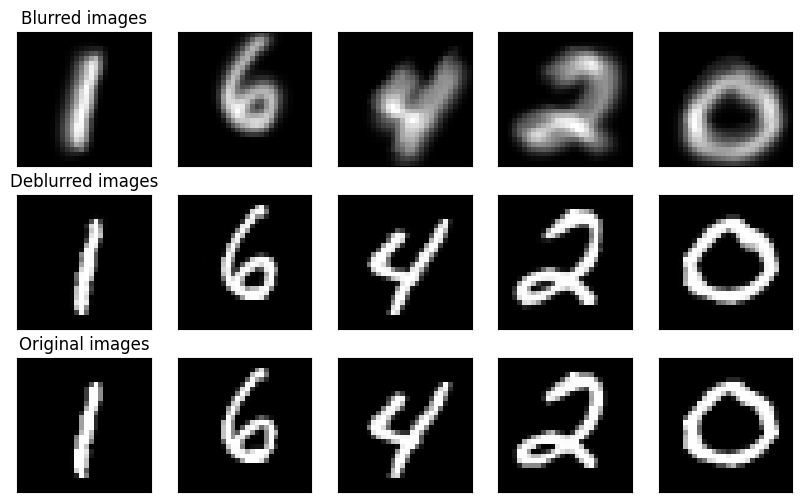

In [ ]:
rand = np.random.randint(x_test.shape[0],size=5)

ground_truth_show = x_test[rand]

blurred_show,ground_truth_show = next(generator(ground_truth_show,5))

blurred_show = np.reshape(blurred_show,newshape=(5,28,28,1)) # reshape per compatibilità con la rete

predict_show = DN.predict(blurred_show)

predict_show = np.reshape(predict_show, (len(predict_show), 28, 28))

plot(blurred_show,predict_show,ground_truth_show)

#Valutazione

Utilizzate Mean Squared Error (mse) per valutare l'errore tra l'immagine deblurred e la ground truth.

Misurate l' mse su 10000 immagini blurred ottenute dal validation set. Ripetete la computazione precedente per 10 volte, e fornite come risutato la media dei 10 round, unitamente alla deviazione standard.

In [ ]:
print('Val Loss durante il training su 10 iterazioni')
list_val_loss = []
for i in range(10):
  blurred_imgs,true_imgs = next(generator(x_test,10000))
  blurred_imgs = np.reshape(blurred_imgs, (10000, 28, 28, 1))
  predict_imgs = DN.predict(blurred_imgs)
  predict_imgs = np.squeeze(predict_imgs)
  list_val_loss.append(np.mean(np.square(true_imgs-predict_imgs)))
print('Val_loss: ',list_val_loss)
print('Mean VL: ',np.mean(list_val_loss))
print('DevStd VL: ',np.std(list_val_loss))

Val Loss durante il training su 10 iterazioni
313/313 [==============================] - 4s 12ms/step
Val_loss:  [0.0023112458, 0.0022679088, 0.0023961072, 0.0022758993, 0.0023849423, 0.002317572, 0.0023287765, 0.0022722487, 0.0022763656, 0.0023967533]
Mean VL:  0.002322782
DevStd VL:  4.9825238e-05
